# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 0.0001
epochs = 10
patience = 2
class_weight_beta = 0.9999

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    embeddings_list = []
    agent_act_types_list = []
    
    nr = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            if speaker == 0:
                if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                skip_bot = False
            else:
                if skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                else: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and 'choice' not in slot_name and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name for slot_name, _ in act_type_relevant_slots]))
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                to_be_retrieved_list.append(list(to_be_retrieved))
                agent_act_types_list.append(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = ', '.join(user_slots_per_act_type) + ' | ' + ', '.join(to_be_retrieved)
                print(input_text)
                
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                embeddings_list.append(embedding)
            
    return embeddings_list, agent_act_types_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_agent_act_types_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_agent_act_types_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_agent_act_types_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  1%|          | 66/6321 [00:00<00:09, 657.96it/s]

restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-food
restaurant-request-food:? | restaurant-name, restaurant-area, restaurant-food
hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | hotel-area, hotel-name, restaurant-name, restaurant-phone
 | 
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-pricerange, hotel-type
hotel-inform-area:south | 
hotel-inform-pricerange:dontcare, restaurant-inform-pricerange:dontcare | hotel-name
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | 
hotel-inform-bookstay:3 | booking-ref
 | 
hotel-inform-name:cityroomz | hotel-type, hotel-pricerange, hotel-area, hotel-name, hotel-address, hotel-stars
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | 
hotel-inform-bookstay:3 | booking-ref
restaurant-inform-area:west, 

  3%|▎         | 212/6321 [00:00<00:09, 631.48it/s]

hotel-inform-area:east, hotel-request-area:? | hotel-area
 | 
 | 
hotel-inform-internet:yes, hotel-inform-pricerange:moderate | hotel-type, hotel-pricerange, hotel-internet
hotel-inform-area:east, hotel-inform-stars:4 | hotel-type
hotel-inform-parking:yes, hotel-request-parking:? | hotel-name, hotel-pricerange, hotel-parking
 | 
 | 
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-stars:5 | hotel-area, hotel-stars
hotel-inform-stars:4 | hotel-area, hotel-name, hotel-type, hotel-stars
hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | 
hotel-inform-bookday:tuesday | booking-ref
 | 
restaurant-inform-area:south, restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:45, restaurant-inform-food:dontcare, restaurant-request-ref:? | booking-ref, booking-bookpeople, booking-name, booking-booktime
 | 
 | hotel-type
hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | 
hotel-inform-area:dontcare, hotel-inform-

  6%|▌         | 351/6321 [00:00<00:09, 648.43it/s]

restaurant-inform-area:centre, restaurant-inform-food:british | restaurant-area, restaurant-food
restaurant-request-name:? | 
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:16:30 | booking-booktime
 | 
hotel-inform-parking:yes, hotel-inform-type:guesthouse | 
hotel-inform-area:north | hotel-pricerange
hotel-request-name:? | hotel-name
hotel-inform-bookstay:3, hotel-request-ref:? | 
hotel-inform-bookpeople:4 | 
hotel-inform-bookday:wednesday | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-parking:no, hotel-inform-type:hotel | 
hotel-inform-area:dontcare, hotel-inform-pricerange:expensive, hotel-inform-stars:4 | hotel-area, hotel-name
hotel-inform-bookday:tuesday, hotel-inform-bookstay:2, hotel-inform-name:huntingdon marriott hotel | 
hotel-inform-bookpeople:1 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookday, booking-bookstay
 | 
hotel-inform-internet:yes, hotel-inform-parking:yes | 
hotel-inform-pricerange:moderate, hot

  8%|▊         | 482/6321 [00:00<00:09, 621.05it/s]

 | 
hotel-inform-pricerange:dontcare | hotel-area, hotel-name
hotel-inform-parking:yes, hotel-inform-pricerange:expensive | hotel-parking, hotel-pricerange, hotel-type, hotel-internet
hotel-inform-pricerange:expensive | hotel-pricerange, hotel-type
hotel-inform-pricerange:moderate | hotel-parking, hotel-pricerange, hotel-type
hotel-request-name:? | hotel-postcode, hotel-name, hotel-address, hotel-phone
hotel-inform-bookday:monday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | 
hotel-inform-bookstay:2 | booking-ref
 | 
 | hotel-area, hotel-name, hotel-type, hotel-stars
hotel-request-name:? | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:16:45 | 
restaurant-inform-booktime:15:45 | booking-ref
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-par

 10%|▉         | 604/6321 [00:00<00:10, 553.74it/s]

hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-name
hotel-inform-stars:5 | hotel-stars
hotel-inform-stars:4 | hotel-parking, hotel-stars, hotel-internet, hotel-area, hotel-type
hotel-inform-bookday:sunday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | 
hotel-inform-area:dontcare | booking-name
hotel-request-ref:? | booking-bookday, booking-name, booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-type
hotel-inform-parking:yes | hotel-name
hotel-request-address:? | hotel-address, hotel-postcode
 | 
restaurant-inform-area:east, restaurant-inform-food:italian, restaurant-inform-pricerange:dontcare | 
restaurant-inform-area:east | restaurant-name
restaurant-request-postcode:? | restaurant-postcode
 | 
restaurant-inform-area:west, restaurant-inform-food:vietnamese, restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-booktime:8:00 p.m. | booking-name
res

 10%|█         | 660/6321 [00:01<00:10, 545.84it/s]

restaurant-inform-name:rajmahal, restaurant-request-phone:? | 
 | 
 | 
hotel-inform-area:west, hotel-inform-stars:0 | 
hotel-inform-internet:yes, hotel-inform-stars:1 | hotel-area, hotel-type, hotel-stars, hotel-internet
hotel-inform-stars:4 | hotel-name
hotel-request-address:?, hotel-request-parking:?, hotel-request-phone:? | hotel-parking, hotel-address, hotel-phone
 | 
hotel-inform-internet:dontcare, hotel-inform-parking:dontcare, hotel-inform-type:guesthouse | hotel-area, hotel-type
hotel-inform-stars:3 | hotel-name, hotel-pricerange, hotel-type
hotel-inform-parking:yes | hotel-name, hotel-parking, hotel-internet
hotel-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-postcode, hotel-name, hotel-address, hotel-phone
 | 
 | 
restaurant-inform-area:east, restaurant-inform-food:spanish, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-area:east, restaurant-inform-food:italian | 
restaurant-request-name

 12%|█▏        | 767/6321 [00:01<00:11, 500.23it/s]

restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone
 | 
restaurant-inform-food:international, restaurant-inform-pricerange:cheap | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-food
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:12:00 | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-request-food:? | restaurant-address, restaurant-name, restaurant-area
restaurant-request-food:? | restaurant-food
restaurant-request-food:? | 
 | 
hotel-inform-name:worth house | hotel-pricerange, hotel-internet, hotel-name, hotel-address, hotel-stars, hotel-type, hotel-parking, hotel-phone, hotel-area, hotel-postcode
 | 
 | 
hotel-inform-internet:yes, hotel-inform-type:hotel | 
hotel-inform-parking:no, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | 
hotel-request-phone:? | hotel-phone
restaurant-inform-bookday:

 14%|█▍        | 877/6321 [00:01<00:10, 508.50it/s]

hotel-inform-parking:yes | 
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | 
hotel-inform-bookstay:1 | booking-bookday, booking-ref
 | 
hotel-inform-name:limehouse | hotel-type, hotel-address, hotel-pricerange, hotel-stars
 | hotel-parking, hotel-internet
 | 
hotel-inform-name:carolina bed and breakfast | booking-name
hotel-request-internet:?, hotel-request-pricerange:? | hotel-parking, hotel-pricerange, hotel-internet, hotel-area, hotel-type
 | hotel-area, hotel-pricerange, hotel-internet
 | 
hotel-inform-parking:yes, hotel-inform-pricerange:expensive | hotel-name, hotel-pricerange, hotel-parking, hotel-phone
hotel-inform-stars:3, hotel-inform-type:guesthouse | hotel-type, hotel-pricerange, hotel-stars
hotel-inform-type:hotel | hotel-area, hotel-name
hotel-request-internet:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-postcode, hotel-phone, hotel-internet
 | 
restaurant-inform-food:asian | 
restaurant-inform-area:dontcare | 
hotel-info

 16%|█▌        | 986/6321 [00:01<00:10, 522.40it/s]

restaurant-inform-area:west, restaurant-inform-food:eritrean | 
restaurant-inform-food:indian | restaurant-pricerange
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:12:15 | booking-name
restaurant-request-ref:? | booking-name, booking-ref
 | 
restaurant-inform-area:north, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-food:european, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-phone, restaurant-name, restaurant-postcode
 | 
restaurant-inform-food:thai, restaurant-inform-pricerange:moderate | 
restaurant-inform-area:east, restaurant-inform-pricerange:moderate | 
restaurant-inform-food:indian | restaurant-name
restaurant-inform-name:curry prince | 
restaurant-inform-bookday:sunday, restaurant-inform-booktime:20:45 | booking-name, booking-ref
 | 
hotel-inform-internet:yes | hotel-internet
hotel-inform-parking:dontcare, hotel-inform-stars:4 | hotel-nam

 18%|█▊        | 1118/6321 [00:01<00:08, 587.16it/s]

hotel-inform-name:gonville hotel, hotel-inform-type:hotel, hotel-request-postcode:? | hotel-postcode
 | 
hotel-inform-pricerange:expensive, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-name, hotel-type
hotel-inform-area:west, hotel-inform-parking:yes | hotel-area, hotel-name, hotel-parking
hotel-inform-bookday:friday, hotel-inform-bookstay:2 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookstay
hotel-inform-area:west | hotel-type
hotel-inform-internet:yes | hotel-name
 | 
hotel-inform-bookday:friday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookday, booking-name, booking-bookstay
 | 
restaurant-inform-area:south, restaurant-inform-food:chinese | 
restaurant-inform-pricerange:expensive | restaurant-name
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:15:15, restaurant-inform-name:peking | booking-ref
 | 
restaurant-inform-area:south, restaurant-inform-pricerange:expensi

 20%|█▉        | 1243/6321 [00:02<00:09, 561.45it/s]

restaurant-inform-food:british | 
restaurant-inform-area:dontcare | booking-name
restaurant-request-ref:? | restaurant-ref
 | 
 | 
restaurant-inform-food:sri lankan, restaurant-inform-pricerange:moderate | restaurant-food
restaurant-inform-area:centre | 
restaurant-inform-food:italian | restaurant-name
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:12:00, restaurant-inform-name:fen ditton | booking-ref, booking-bookday, booking-name, booking-booktime
hotel-inform-parking:yes, hotel-inform-stars:5, hotel-inform-type:hotel | hotel-type, hotel-stars
hotel-inform-stars:3 | hotel-area, hotel-type, hotel-stars
hotel-inform-area:dontcare, hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | hotel-name, booking-ref
 | 
restaurant-inform-food:thai, restaurant-inform-pricerange:moderate | 
restaurant-inform-food:european, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-food
restaurant-request-name:?

 21%|██▏       | 1357/6321 [00:02<00:08, 557.45it/s]

restaurant-inform-area:centre | restaurant-name
restaurant-inform-bookpeople:1, restaurant-inform-booktime:20:15 | booking-ref
 | 
hotel-inform-type:hotel | 
hotel-inform-pricerange:expensive, hotel-inform-stars:3, restaurant-request-pricerange:? | hotel-pricerange, hotel-stars
hotel-inform-internet:yes, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-type, hotel-pricerange, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-inform-bookday:saturday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | 
hotel-request-ref:?, restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-name
restaurant-request-address:? | restaurant-address, booking-ref
 | 
restaurant-inform-name:anatolia | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookpeople:8 | booking-bookpeople, booking-bookday, booking-booktime
restaurant-inform-bookday:friday, restaurant-inform-booktime:13:00, restaurant-request-ref:? | booking-ref, booking-bookday, bo

 23%|██▎       | 1473/6321 [00:02<00:08, 561.93it/s]

hotel-inform-area:north, hotel-inform-type:guesthouse | hotel-type
hotel-inform-pricerange:expensive | hotel-pricerange, hotel-type
hotel-inform-pricerange:moderate | hotel-name
hotel-inform-name:acorn guest house, hotel-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-postcode, hotel-name, hotel-address, hotel-phone
 | 
hotel-inform-internet:yes | 
hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | 
hotel-inform-area:dontcare, hotel-request-area:?, hotel-request-parking:? | 
hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-name, hotel-internet
hotel-request-area:?, hotel-request-parking:? | hotel-name, hotel-parking
 | 
restaurant-inform-name:eraina | restaurant-area
 | restaurant-address, restaurant-postcode
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:14:30, restaurant-request-ref:? | booking-ref, booking-bookday, booking-booktime
 | 
restaurant-inform-area:west, restaura

 25%|██▌       | 1585/6321 [00:02<00:08, 540.67it/s]

hotel-inform-area:centre, hotel-inform-type:hotel | hotel-area, hotel-pricerange
hotel-inform-internet:yes | hotel-name, hotel-type, hotel-pricerange, hotel-internet
hotel-request-parking:? | hotel-parking, hotel-internet
restaurant-inform-area:west, restaurant-inform-food:polish, restaurant-inform-pricerange:expensive | restaurant-area, restaurant-food
restaurant-inform-food:british | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:17:00 | booking-ref
 | 
restaurant-inform-area:north, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-area
restaurant-inform-area:north | restaurant-address, restaurant-name
restaurant-request-phone:? | restaurant-phone, restaurant-name
 | 
restaurant-inform-area:south, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-bookpeople:5 | booking-name, booking-ref
 | 
restaurant-inform-bookday:tuesday,

 26%|██▌       | 1640/6321 [00:02<00:08, 522.07it/s]

hotel-inform-parking:yes, hotel-inform-stars:0 | hotel-area, hotel-type
hotel-inform-area:east | 
hotel-inform-area:north | hotel-name
hotel-inform-bookday:saturday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | 
hotel-inform-pricerange:cheap | 
hotel-inform-area:dontcare, hotel-inform-parking:dontcare, hotel-inform-stars:dontcare | booking-name, booking-ref
 | hotel-address
 | 
restaurant-inform-area:south, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-name, restaurant-area
restaurant-request-name:? | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:? | restaurant-address, restaurant-name
 | 
 | 
hotel-inform-pricerange:cheap | hotel-pricerange
hotel-request-address:?, hotel-request-area:? | hotel-area, hotel-name, hotel-address
 | 
hotel-inform-pricerange:cheap, hotel-inform-stars:3, hotel-inform-type:hotel | 
hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-parking, hotel-stars, hotel-in

 28%|██▊       | 1743/6321 [00:03<00:09, 482.11it/s]

hotel-inform-area:centre, hotel-inform-type:hotel | 
hotel-inform-pricerange:expensive | hotel-name, hotel-address, hotel-stars
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4, hotel-inform-stars:4 | booking-ref
 | 
restaurant-inform-food:european | restaurant-address, restaurant-name
 | 
hotel-inform-name:archway house | hotel-address, hotel-pricerange
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4 | booking-ref
 | 
hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-parking, hotel-type
hotel-inform-internet:dontcare | hotel-area, hotel-name, hotel-pricerange
hotel-inform-internet:yes, hotel-inform-name:leverton house | hotel-name, hotel-internet
hotel-request-postcode:? | hotel-postcode
hotel-request-pricerange:? | hotel-name, hotel-pricerange
 | 
restaurant-inform-area:centre, restaurant-inform-food:malay | restaurant-area, restaurant-food
restaurant-inform-food:indian | 
restaurant-inform-bookpeople:6,

 29%|██▉       | 1862/6321 [00:03<00:08, 528.32it/s]

 | 
restaurant-inform-food:jamaican, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-food
restaurant-inform-area:centre | 
restaurant-inform-food:modern european | restaurant-food, restaurant-area, booking-name
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode
 | 
restaurant-inform-pricerange:moderate | restaurant-pricerange
restaurant-inform-food:jamaican | restaurant-food
restaurant-inform-food:european | restaurant-name, restaurant-area
restaurant-request-phone:? | restaurant-phone
 | 
restaurant-inform-area:centre, restaurant-inform-food:italian, restaurant-inform-pricerange:expensive, restaurant-request-phone:? | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
 | restaurant-name
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-name, restaurant-area
 | 
restaurant-inform-name:rice boat | restaurant-name, re

 31%|███       | 1973/6321 [00:03<00:08, 524.33it/s]

 | 
 | 
 | 
restaurant-request-phone:? | restaurant-phone
restaurant-request-address:? | restaurant-address, restaurant-name
 | 
restaurant-inform-area:east, restaurant-inform-food:chinese | restaurant-name, restaurant-food
restaurant-request-phone:? | restaurant-phone
hotel-inform-parking:yes, hotel-inform-stars:4 | hotel-stars
hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-name
hotel-inform-bookday:sunday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3, hotel-inform-name:university arms hotel, hotel-inform-type:hotel | booking-ref
 | 
restaurant-inform-food:international, restaurant-inform-pricerange:moderate, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-postcode
 | 
restaurant-inform-area:centre, restaurant-inform-food:british | restaurant-pricerange, restaurant-food
restaurant-inform-pricerange:moderate | restaurant-address, restaurant-name
hotel-in

 33%|███▎      | 2083/6321 [00:03<00:07, 532.94it/s]

restaurant-inform-area:centre, restaurant-inform-food:danish | 
restaurant-inform-food:european, restaurant-inform-pricerange:cheap | 
restaurant-inform-food:indian | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
restaurant-inform-area:centre, restaurant-inform-food:spanish | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-name:la raza's, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-postcode
 | 
 | 
 | 
restaurant-inform-name:yippee noodle bar | restaurant-address, restaurant-pricerange, restaurant-area, restaurant-food, restaurant-phone
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:13:45 | booking-ref
hotel-inf

 35%|███▍      | 2195/6321 [00:04<00:08, 503.62it/s]

restaurant-inform-bookpeople:1, restaurant-inform-booktime:18:15 | booking-bookday, booking-booktime, booking-bookpeople, booking-name, booking-ref
 | 
 | 
hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-name, hotel-parking, hotel-type
hotel-request-name:? | booking-name
hotel-request-area:? | hotel-area, hotel-name
restaurant-inform-food:italian, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-area
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:17:30 | booking-ref
 | 
restaurant-inform-area:east, restaurant-inform-food:international | restaurant-address, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:12:30 | 
restaurant-inform-pricerange:cheap | 
restaurant-inform-area:east, restaurant-inform-pricerange:cheap | 
restaurant-inform-area:dontcar

 37%|███▋      | 2313/6321 [00:04<00:07, 543.13it/s]

restaurant-inform-area:east | restaurant-pricerange, restaurant-name, restaurant-area
restaurant-request-name:? | 
restaurant-inform-food:british | restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-postcode
 | 
 | 
restaurant-inform-area:west, restaurant-inform-food:northern european | restaurant-food
restaurant-inform-food:mexican | restaurant-food
restaurant-inform-food:indian | restaurant-name
restaurant-request-address:?, restaurant-request-postcode:? | 
restaurant-inform-name:maharajah tandoon | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-food, restaurant-phone
hotel-inform-name:hamilton lodge | hotel-area, hotel-name, hotel-pricerange, hotel-type
 | 
restaurant-inform-booktime:12:30 | booking-ref
 | 
 | 
 | 
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:12:00, restaurant-inform-name:the lucky star |

 38%|███▊      | 2433/6321 [00:04<00:06, 567.36it/s]

restaurant-inform-food:mediterranean | restaurant-name, restaurant-area
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone
hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-area, hotel-pricerange, hotel-internet
hotel-inform-pricerange:expensive | hotel-area, hotel-name, hotel-pricerange, hotel-internet
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | 
hotel-inform-bookday:friday, hotel-request-ref:? | booking-ref
 | 
hotel-inform-internet:yes | hotel-parking, hotel-internet
hotel-inform-bookday:sunday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | 
hotel-inform-bookstay:1 | booking-ref
restaurant-inform-food:modern global, restaurant-inform-pricerange:cheap | restaurant-food
restaurant-inform-food:italian | 
restaurant-inform-area:centre | restaurant-name
restaurant-inform-name:zizzi cambridge | 
restaurant-request-ref:? | 
restaurant-inform-bookday:thursday, restaurant-infor

 40%|████      | 2552/6321 [00:04<00:06, 579.83it/s]

restaurant-inform-food:traditional | 
restaurant-inform-food:european | 
restaurant-request-name:? | restaurant-phone, restaurant-name, restaurant-area
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:13:15, restaurant-request-ref:? | restaurant-ref
 | 
 | 
hotel-inform-pricerange:expensive, hotel-inform-type:guesthouse | hotel-pricerange, hotel-type
hotel-inform-pricerange:moderate | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | booking-bookpeople, booking-bookday, booking-name, booking-ref
 | 
hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-parking, hotel-type
hotel-inform-area:south, hotel-inform-pricerange:moderate | hotel-name, hotel-parking, hotel-internet
hotel-request-name:? | hotel-name
hotel-request-postcode:? | hotel-postcode
 | 
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
restaurant-info

 41%|████▏     | 2612/6321 [00:04<00:06, 585.37it/s]

 | 
restaurant-inform-area:centre | 
restaurant-inform-food:chinese | restaurant-name
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:00, restaurant-inform-name:ugly duckling | booking-ref
 | 
hotel-inform-name:autumn house | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
 | 
hotel-request-phone:? | hotel-phone
 | 
restaurant-inform-food:mediterranean, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
 | 
hotel-inform-area:east, hotel-inform-type:hotel | hotel-name
hotel-inform-stars:4 | hotel-stars
hotel-inform-area:east, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-area, hotel-stars
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4, hotel-inform-stars:4 | booking-ref
restaurant-inform-food:gastropub | restaurant-address, restaurant-name, restaurant-food
restaurant-inform-bookday:tuesday, restaurant-inform-bo

 43%|████▎     | 2730/6321 [00:04<00:06, 549.98it/s]

restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:19:45 | booking-bookday, booking-name, booking-ref
 | 
restaurant-inform-area:east, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:swedish | 
restaurant-inform-food:chinese | restaurant-name
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:15 | 
restaurant-request-ref:? | booking-ref
 | 
hotel-inform-area:centre, hotel-inform-bookstay:2, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-area, hotel-stars
hotel-inform-area:centre, hotel-inform-stars:2 | 
hotel-inform-stars:2 | hotel-area, hotel-stars
restaurant-inform-area:centre, restaurant-inform-food:italian | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-name
restaurant-inform-name:zizzi cambridge, restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, rest

 45%|████▌     | 2846/6321 [00:05<00:06, 553.53it/s]

 | 
restaurant-inform-name:tandoori | restaurant-name, restaurant-area
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-phone
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:indian | restaurant-pricerange, restaurant-name, restaurant-food
restaurant-inform-name:loch fyne | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:30 | booking-ref
 | 
 | 
hotel-inform-parking:yes | 
hotel-inform-area:east, hotel-inform-internet:yes | hotel-type, hotel-pricerange, hotel-parking, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-request-postcode:? | hotel-postcode
 | 
hotel-inform-stars:0, hotel-inform-type:hotel | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
 | hotel-phone, hotel-area, hotel-name, hotel-address, hotel-postcode
hotel-request-internet:? | ho

 47%|████▋     | 2976/6321 [00:05<00:06, 542.93it/s]

hotel-inform-name:finches, hotel-request-ref:? | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-food:canapes | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:european | restaurant-name
restaurant-request-postcode:? | restaurant-postcode
 | 
restaurant-inform-area:north, restaurant-inform-food:cantonese | 
restaurant-inform-pricerange:dontcare | restaurant-area, restaurant-food
restaurant-inform-area:north, restaurant-inform-food:asian oriental | restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-name, restaurant-phone
 | 
restaurant-inform-name:royal standard | restaurant-address, restaurant-name
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:1145 | 
restaurant-inform-bookday:friday | booking-ref
 | 
hotel-inform-pricerange:cheap, hotel-inform-type:hotel | 
hotel-inform-parking:yes | 

 49%|████▉     | 3089/6321 [00:05<00:06, 537.03it/s]

hotel-inform-bookday:tuesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | 
hotel-inform-bookstay:1 | booking-bookpeople, booking-bookday
hotel-request-ref:? | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-food:chinese | 
restaurant-inform-pricerange:dontcare | restaurant-address, restaurant-pricerange, restaurant-name
restaurant-inform-bookday:sunday | 
hotel-inform-name:gonville hotel | hotel-pricerange, hotel-stars
hotel-request-area:? | hotel-area
restaurant-inform-area:centre, restaurant-inform-food:indian | restaurant-pricerange
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:30 | booking-name, booking-ref
 | 
hotel-inform-area:south, hotel-inform-pricerange:moderate | hotel-area, hotel-pricerange, hotel-type
hotel-inform-area:south, hotel-inform-internet:yes, hotel-inform-pricerange:moderate | hotel-pricerange, hotel-stars, hotel-internet, hotel-area, hotel-type
hotel-inform-parking:yes, hotel-request-p

 51%|█████     | 3197/6321 [00:05<00:06, 511.91it/s]

restaurant-request-name:? | 
hotel-inform-bookstay:2, hotel-inform-internet:yes, hotel-inform-stars:2 | hotel-area
hotel-inform-area:dontcare, hotel-inform-parking:yes | hotel-pricerange, hotel-type
hotel-inform-bookday:thursday, hotel-inform-bookstay:2, hotel-inform-stars:2 | 
hotel-inform-bookpeople:5, hotel-inform-bookstay:2, hotel-inform-stars:2, hotel-request-ref:? | booking-ref
 | 
 | 
 | 
restaurant-inform-area:west, restaurant-inform-pricerange:expensive | restaurant-food
restaurant-inform-food:dontcare | restaurant-name, restaurant-food
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-phone
 | 
hotel-inform-internet:yes, hotel-inform-parking:dontcare, hotel-inform-type:guesthouse | 
hotel-inform-pricerange:moderate | hotel-area, hotel-name, hotel-pricerange, hotel-internet
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | booking-ref
 | 
restaurant-inform-pricerange:expensive | restaurant-address, restau

 52%|█████▏    | 3258/6321 [00:05<00:05, 537.68it/s]

 | 
restaurant-inform-area:east, restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-name, restaurant-area
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-phone
 | 
restaurant-inform-food:french | restaurant-name
restaurant-inform-name:cote | 
restaurant-inform-pricerange:moderate | restaurant-pricerange
restaurant-inform-food:asian oriental | restaurant-pricerange, restaurant-name
restaurant-request-address:? | restaurant-address, restaurant-name, restaurant-area
 | 
hotel-inform-area:north, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-name
hotel-inform-type:guesthouse | hotel-area, hotel-type, hotel-stars
hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-name, hotel-address, hotel-postcode
hotel-request-parking:? | hotel-parking
restaurant-inform-area:north, restaurant-inform-food:persian | restaurant-area, restaurant-food
restaurant-inform-food:italian | restaurant-addres

 53%|█████▎    | 3367/6321 [00:06<00:05, 533.05it/s]

restaurant-request-address:? | restaurant-address
 | 
restaurant-inform-pricerange:moderate | 
restaurant-inform-food:catalan | 
restaurant-inform-food:spanish | restaurant-pricerange, restaurant-name, restaurant-food
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-postcode
 | 
 | 
hotel-inform-name:express by holiday inn - cambridge | hotel-pricerange, hotel-internet, hotel-address, hotel-stars, hotel-parking, hotel-phone, hotel-area, hotel-postcode
hotel-inform-bookstay:3 | 
hotel-inform-bookday:saturday, hotel-inform-bookpeople:6 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-stars:4 | 
hotel-inform-area:north, hotel-inform-pricerange:moderate | 
hotel-inform-parking:yes, hotel-request-parking:? | hotel-name
hotel-request-name:? | hotel-postcode, hotel-name, hotel-address, hotel-phone
restaurant-inform-food:chinese, restaurant-inform-pricerange:moderate | restaurant

 55%|█████▌    | 3488/6321 [00:06<00:05, 561.09it/s]

restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:18:00 | 
restaurant-inform-booktime:5pm | booking-ref
restaurant-inform-area:south, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-pricerange:expensive | restaurant-name
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:17:45 | 
restaurant-request-ref:? | booking-ref
 | 
hotel-inform-area:south, hotel-inform-bookday:monday, hotel-inform-bookpeople:4, hotel-inform-bookstay:5, hotel-inform-type:guesthouse | hotel-name
 | 
hotel-request-ref:? | booking-ref
 | 
restaurant-inform-food:traditional, restaurant-inform-pricerange:moderate | 
restaurant-inform-food:spanish, restaurant-inform-pricerange:moderate | restaurant-name
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
restaurant-inform-area:we

 57%|█████▋    | 3602/6321 [00:06<00:04, 544.52it/s]

restaurant-request-name:? | booking-bookday, booking-name, booking-ref
 | 
hotel-inform-name:leverton house | 
hotel-inform-bookday:thursday, hotel-inform-bookstay:2 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookday, booking-bookstay
 | 
restaurant-inform-name:da vinci pizzeria | restaurant-address, restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:12:45 | booking-ref
 | 
 | 
hotel-inform-pricerange:moderate, hotel-inform-type:hotel | hotel-pricerange, hotel-type
hotel-inform-internet:dontcare, hotel-inform-stars:3 | hotel-stars
hotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | booking-name, booking-ref
 | 
 | 
restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-name
restaurant-request-food:? | restaurant-name, restaurant-food
restaurant-inform-name:pizza hut cherry, restaurant-request-address:?, restaurant-request-p

 59%|█████▉    | 3720/6321 [00:06<00:05, 509.97it/s]

hotel-inform-pricerange:moderate | hotel-name, hotel-pricerange, booking-name
hotel-inform-name:acorn guest house | booking-ref
 | 
restaurant-inform-area:dontcare, restaurant-inform-food:scandinavian | 
restaurant-inform-food:vietnamese | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-name:thanh binh, restaurant-request-address:?, restaurant-request-phone:? | restaurant-phone
restaurant-request-address:? | restaurant-address, restaurant-name
 | 
restaurant-inform-pricerange:cheap | 
restaurant-inform-food:italian | restaurant-name, restaurant-food
restaurant-inform-area:north | restaurant-name, restaurant-area
restaurant-inform-area:north | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:30 | booking-ref
 | 
restaurant-inform-area:south | restaurant-area
restaurant-inform-food:italian, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-a

 61%|██████    | 3833/6321 [00:06<00:04, 531.01it/s]

restaurant-inform-food:dontcare | restaurant-address, restaurant-name
restaurant-request-phone:? | restaurant-phone, restaurant-name
restaurant-request-address:? | restaurant-address, restaurant-name
restaurant-request-food:? | restaurant-food
 | 
hotel-inform-parking:yes, hotel-inform-stars:3 | 
hotel-inform-pricerange:moderate | hotel-area, hotel-name
hotel-inform-name:hobson's house | 
hotel-inform-bookstay:3 | 
hotel-inform-bookday:friday, hotel-inform-bookpeople:7 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookpeople, booking-bookday, booking-bookstay
 | 
restaurant-inform-name:bedouin | restaurant-address, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:18:00 | booking-ref
 | 
hotel-inform-area:west | rest

 62%|██████▏   | 3941/6321 [00:07<00:04, 530.06it/s]

 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-food
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:17:45, restaurant-inform-food:chinese | booking-name, booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-food:african | restaurant-name
restaurant-inform-name:bedouin | restaurant-address
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:11:30 | booking-ref
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-food
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:16:30 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-type:hotel | 
hotel-request-area:? | 
hotel-inform-pricerange:expensive | hotel-name
hotel-inform-type:hotel | hotel-type
hotel-inform-type:guesthouse | hotel-type
hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | 

 64%|██████▍   | 4050/6321 [00:07<00:04, 484.31it/s]

hotel-inform-parking:yes | 
hotel-inform-bookstay:2, hotel-inform-parking:yes | 
hotel-inform-bookday:thursday, hotel-inform-bookstay:2 | booking-name, booking-ref
hotel-inform-pricerange:expensive | 
hotel-inform-area:dontcare, restaurant-request-area:? | hotel-name, hotel-stars, hotel-parking, hotel-internet
hotel-inform-internet:yes, hotel-inform-parking:yes | 
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | booking-name, booking-ref
hotel-inform-pricerange:moderate, restaurant-inform-food:modern european, restaurant-inform-pricerange:moderate | restaurant-area
restaurant-request-area:? | restaurant-area
restaurant-request-area:? | hotel-pricerange, hotel-type
 | restaurant-area
restaurant-inform-food:northern european | restaurant-name
restaurant-request-address:?, restaurant-request-area:? | restaurant-address, restaurant-area
 | 
restaurant-inform-food:british, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:dontcare, restaurant

 66%|██████▌   | 4161/6321 [00:07<00:04, 514.43it/s]

hotel-inform-bookday:thursday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | 
 | 
hotel-inform-stars:dontcare | 
 | hotel-area, hotel-name
hotel-inform-name:gonville hotel | booking-bookday, booking-bookpeople, booking-bookstay, booking-name, booking-ref
 | 
hotel-inform-name:warkworth house | hotel-type, hotel-pricerange, hotel-parking, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-inform-bookstay:4 | 
 | 
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4 | booking-ref
restaurant-inform-area:centre, restaurant-inform-food:greek | restaurant-area, restaurant-food
restaurant-inform-food:british | restaurant-address, restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:00 | booking-ref
 | 
restaurant-inform-area:centre | 
restaurant-inform-food:french | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restau

 68%|██████▊   | 4269/6321 [00:07<00:03, 525.81it/s]

 | 
hotel-inform-name:kirkwood house | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
hotel-request-address:? | hotel-name, hotel-address, hotel-postcode
 | 
 | 
restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-food
hotel-inform-parking:yes, hotel-inform-stars:3 | hotel-area, hotel-type
hotel-inform-area:south, hotel-inform-type:guesthouse | hotel-type
hotel-inform-area:centre | hotel-type
 | hotel-area, hotel-name, hotel-pricerange, hotel-stars
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3, hotel-inform-name:el shaddai | booking-ref
 | 
 | 
restaurant-inform-area:north, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-food:indian, restaurant-request-food:?, restaurant-request-phone:? | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
 | 
restaurant-request-phon

 68%|██████▊   | 4322/6321 [00:07<00:04, 495.10it/s]

hotel-inform-stars:4 | hotel-area
hotel-inform-bookstay:5, hotel-request-ref:? | 
hotel-request-name:? | hotel-name
hotel-request-name:? | booking-ref
 | 
hotel-inform-area:east, hotel-inform-pricerange:moderate | hotel-area, hotel-pricerange, hotel-type
hotel-inform-area:east, hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-parking, hotel-internet, hotel-area, hotel-name, hotel-type
 | 
hotel-inform-area:north, hotel-inform-type:hotel | hotel-area, hotel-type
hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-name
hotel-inform-pricerange:moderate | hotel-parking, hotel-pricerange, hotel-internet, hotel-name, hotel-type
hotel-inform-type:guesthouse, hotel-request-phone:?, hotel-request-postcode:? | hotel-stars, hotel-phone, hotel-postcode, hotel-address, hotel-type
 | 
hotel-inform-area:south, hotel-inform-type:hotel | hotel-parking, hotel-type, hotel-internet
hotel-inform-type:hotel | hotel-name, hotel-pricerange, hotel-typ

 70%|██████▉   | 4424/6321 [00:08<00:03, 487.38it/s]

hotel-inform-bookpeople:4, hotel-inform-bookstay:4, hotel-inform-type:hotel | hotel-name
 | 
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | booking-ref
 | 
hotel-inform-parking:yes, hotel-inform-type:hotel | 
 | hotel-area, hotel-name, hotel-pricerange
hotel-inform-stars:2, hotel-inform-type:hotel | hotel-stars
hotel-inform-stars:2, hotel-inform-type:hotel | hotel-area, hotel-stars, hotel-type
hotel-inform-bookstay:2, hotel-inform-stars:2 | hotel-area
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | 
hotel-inform-bookstay:2 | booking-bookstay
hotel-request-ref:? | booking-ref
 | 
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name
hotel-inform-stars:4 | hotel-stars, hotel-area, hotel-type
hotel-inform-stars:4, hotel-inform-type:hotel | hotel-type
hotel-inform-type:guesthouse | 
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | booking-name, booking-ref
 | 
 | 
re

 72%|███████▏  | 4534/6321 [00:08<00:03, 473.63it/s]

 | 
restaurant-inform-area:west | restaurant-area
restaurant-inform-food:british, restaurant-inform-pricerange:expensive | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:18:15, restaurant-request-ref:? | booking-name, booking-ref
 | 
restaurant-inform-area:west, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-food
restaurant-inform-food:thai | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:00 | 
restaurant-inform-booktime:14:00 | booking-ref
 | 
restaurant-inform-bookday:sunday, restaurant-inform-booktime:15:30, restaurant-inform-name:dontcare | booking-name, booking-ref
 | 
 | 
hotel-inform-parking:yes, hotel-inform-pricerange:expensive | 
hotel-inform-area:north | hotel-area
hotel-inform-pricerange:cheap | hotel-type
hotel-inform-type:guesthouse | hotel-name
 | hotel-star

 73%|███████▎  | 4638/6321 [00:08<00:03, 490.73it/s]

restaurant-inform-food:italian, restaurant-request-address:?, restaurant-request-phone:? | restaurant-phone, restaurant-name
 | 
restaurant-inform-name:india house | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:00 | booking-booktime
restaurant-inform-booktime:11:00 | booking-ref, booking-bookpeople, booking-bookday, booking-booktime
 | 
hotel-inform-type:guesthouse | 
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-type
hotel-inform-bookday:saturday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | booking-bookpeople, booking-bookday, booking-name, booking-bookstay
hotel-request-ref:? | 
hotel-inform-pricerange:moderate, hotel-inform-type:hotel | hotel-address, booking-name, booking-ref
 | 
 | 
hotel-inform-internet:yes, hotel-inform-parking:dontcare | hotel-name, hotel-type
hotel-inform-area:nort

 75%|███████▌  | 4750/6321 [00:08<00:03, 499.55it/s]

restaurant-inform-name:midsummer house restaurant | 
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:00 | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-food:modern eclectic | 
restaurant-request-food:? | restaurant-food
restaurant-inform-food:thai | restaurant-name
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:16:45 | 
restaurant-inform-booktime:15:45 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-stars:2 | hotel-area, hotel-pricerange, hotel-type
hotel-inform-pricerange:cheap | hotel-area, hotel-type, hotel-pricerange, hotel-stars
hotel-inform-pricerange:moderate, hotel-inform-stars:2 | hotel-name
hotel-inform-bookday:friday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4, hotel-inform-stars:2 | booking-bookstay
hotel-inform-pricerange:cheap, hotel-inform-stars:2 | 
hotel-inform-internet:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:2 | hotel-p

 77%|███████▋  | 4854/6321 [00:09<00:02, 506.21it/s]

hotel-inform-stars:2, hotel-inform-type:hotel | hotel-area, hotel-stars
hotel-inform-area:east | hotel-area, hotel-name
hotel-inform-bookday:saturday, hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | 
hotel-request-ref:? | booking-ref
 | 
hotel-inform-parking:no, hotel-inform-type:hotel | hotel-type
hotel-inform-area:south | hotel-area, hotel-type
hotel-inform-parking:yes | hotel-parking, hotel-pricerange, hotel-stars
hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | booking-ref
 | 
hotel-inform-area:north, hotel-inform-internet:yes | hotel-area, hotel-internet
hotel-inform-pricerange:moderate | hotel-type
hotel-inform-type:guesthouse, hotel-request-postcode:? | hotel-pricerange, hotel-stars, hotel-name, hotel-postcode, hotel-type
hotel-inform-parking:yes, hotel-request-parking:? | hotel-name, hotel-parking
hotel-request-area:?, restaurant-inform-area:north, restaurant-inform-pricerange:cheap | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:3, r

 78%|███████▊  | 4957/6321 [00:09<00:02, 487.97it/s]

hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-address, restaurant-name
restaurant-inform-food:german, restaurant-inform-name:bedouin | restaurant-food
 | restaurant-pricerange, restaurant-food
restaurant-inform-food:japanese | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:17:15, restaurant-request-ref:? | booking-ref
 | 
hotel-inform-parking:no, hotel-inform-pricerange:expensive | 
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name
restaurant-request-phone:? | 
hotel-inform-area:centre | hotel-parking, hotel-pricerange, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-request-postcode:?, restaurant-request-address:? | hotel-type, hotel-postcode
restaurant-inform-food:chinese | restaurant-pricerange, restaurant-area, restaurant

 80%|████████  | 5065/6321 [00:09<00:03, 393.88it/s]

restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:45, restaurant-inform-name:curry prince | booking-ref
 | 
 | 
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:east | restaurant-name, restaurant-area
restaurant-inform-name:sitar tandoori, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
hotel-inform-type:hotel | 
hotel-inform-area:east, hotel-inform-stars:3 | 
hotel-inform-parking:yes, hotel-inform-stars:4 | 
hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4, hotel-inform-stars:4 | 
hotel-inform-parking:yes, hotel-inform-stars:4 | 
hotel-inform-bookstay:4, hotel-inform-stars:3 | hotel-area, hotel-type
hotel-inform-area:centre, hotel-inform-stars:4 | hotel-type, hotel-stars
hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4, hote

 82%|████████▏ | 5176/6321 [00:09<00:02, 431.86it/s]

restaurant-inform-bookday:monday, restaurant-inform-bookpeople:4 | 
restaurant-inform-booktime:15:30 | booking-ref
 | 
hotel-inform-area:north, hotel-inform-type:guesthouse | 
hotel-inform-stars:4 | hotel-parking, hotel-internet
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2, hotel-inform-internet:yes | booking-ref
restaurant-inform-area:north, restaurant-inform-food:north african | restaurant-food
restaurant-inform-pricerange:expensive | 
restaurant-inform-area:north, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-food:chinese | restaurant-name
restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:45 | 
 | 
restaurant-inform-name:restaurant one seven | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:14:15 | 
restaurant-inform-booktime:13:15 | booking-ref
 | 


 84%|████████▎ | 5282/6321 [00:10<00:02, 472.96it/s]

restaurant-inform-bookday:monday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:15:00, restaurant-inform-pricerange:dontcare | restaurant-pricerange, restaurant-name, restaurant-area, booking-ref
 | 
restaurant-inform-food:halal | 
restaurant-inform-food:portuguese | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-phone:? | restaurant-address, restaurant-phone
 | 
 | 
hotel-inform-stars:4 | hotel-stars
hotel-inform-area:south, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-area, hotel-type, hotel-stars
hotel-inform-area:south, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-pricerange, hotel-type
hotel-inform-internet:yes, hotel-request-internet:? | hotel-name, hotel-pricerange, hotel-internet
hotel-request-postcode:? | hotel-postcode
restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-name, restaurant-food
hotel-inform-area:south, restaurant-inform-area:south

 85%|████████▌ | 5400/6321 [00:10<00:01, 527.05it/s]

 | 
restaurant-inform-name:golden wok | hotel-area, hotel-address, hotel-pricerange
restaurant-inform-bookday:friday | 
restaurant-inform-bookpeople:7, restaurant-inform-booktime:11:15 | booking-bookday, booking-name, booking-ref
hotel-inform-internet:yes, hotel-inform-stars:5 | hotel-stars, hotel-type
hotel-inform-stars:4 | hotel-pricerange, hotel-type
hotel-inform-pricerange:dontcare, hotel-inform-type:hotel | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
hotel-inform-bookday:friday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | booking-ref
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | 
restaurant-inform-food:dontcare | restaurant-name
restaurant-request-address:?, restaurant-request-food:? | restaurant-address, restaurant-food
restaurant-request-name:? | 
restaurant-inform-area:east, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:tuscan | restaurant-area, restaurant-food
restaurant-inform-area:east, restau

 87%|████████▋ | 5506/6321 [00:10<00:01, 496.32it/s]

restaurant-inform-area:north, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-name:nirala, restaurant-request-phone:? | restaurant-phone, restaurant-name
restaurant-request-address:? | restaurant-address
restaurant-request-address:? | restaurant-name, restaurant-postcode
 | 
hotel-inform-parking:yes | hotel-name, hotel-pricerange, hotel-stars, hotel-type
hotel-inform-pricerange:expensive | hotel-type, hotel-pricerange, hotel-stars
hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | 
hotel-inform-bookstay:1 | booking-name, booking-ref
hotel-inform-pricerange:expensive, restaurant-inform-food:north american, restaurant-inform-pricerange:expensive | restaurant-name, restaurant-area
 | 
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-postcode
 | 
hotel-inform-parking:yes, hotel-inform-stars:3 | 
hotel-inform-interne

 89%|████████▉ | 5615/6321 [00:10<00:01, 501.17it/s]

hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-area, hotel-type, hotel-stars
hotel-inform-area:centre, hotel-inform-internet:yes, hotel-request-internet:? | hotel-name
hotel-request-internet:? | hotel-name, hotel-internet
hotel-inform-internet:yes | 
hotel-request-address:? | hotel-address
 | 
 | hotel-area, hotel-type
hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-pricerange:dontcare | hotel-parking, hotel-pricerange, hotel-internet, hotel-area, hotel-name, hotel-type
 | 
hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | booking-ref
restaurant-inform-name:restaurant called two two | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:11:00 | booking-ref
 | 
restaurant-inform-food:indian | restaurant-food
restaurant-inform-area:north, restaurant-inform-food:indian, restaurant-inform-p

 91%|█████████ | 5721/6321 [00:10<00:01, 510.14it/s]

hotel-inform-bookday:thursday | 
hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | booking-bookpeople, booking-bookstay
hotel-request-ref:? | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-food:italian | 
restaurant-inform-pricerange:dontcare | restaurant-name
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:13:15 | booking-ref
 | 
hotel-inform-name:allenbell | hotel-name, hotel-address, hotel-phone
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3 | 
hotel-inform-pricerange:cheap, hotel-inform-type:hotel | hotel-ref, hotel-address, booking-name
 | 
hotel-inform-stars:4, hotel-inform-type:guesthouse | 
hotel-inform-area:south | hotel-area, hotel-type, hotel-pricerange, hotel-stars
hotel-inform-bookday:wednesday, hotel-inform-bookstay:2 | hotel-name
 | 
hotel-inform-bookpeople:1 | booking-ref
 | 
restaurant-inform-food:modern european, restaurant-inform-pric

 92%|█████████▏| 5832/6321 [00:11<00:00, 532.32it/s]

restaurant-inform-area:dontcare, restaurant-inform-food:cuban | restaurant-pricerange, restaurant-food
restaurant-inform-food:international, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-name, restaurant-postcode
 | 
hotel-inform-internet:yes, hotel-inform-stars:5, hotel-inform-type:hotel | hotel-type, hotel-stars
hotel-inform-pricerange:moderate | hotel-area, hotel-name, hotel-pricerange
 | 
hotel-inform-bookstay:2 | 
hotel-inform-bookday:friday, hotel-inform-bookpeople:8 | booking-ref
hotel-inform-stars:4 | hotel-stars
 | 
restaurant-inform-food:kosher, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-food
restaurant-inform-area:centre | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-food:italian | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-area, 

 93%|█████████▎| 5886/6321 [00:11<00:00, 508.04it/s]

 | 
restaurant-inform-area:centre, restaurant-inform-food:gastropub | restaurant-area, restaurant-food
restaurant-inform-pricerange:expensive | restaurant-address, restaurant-name, restaurant-area
restaurant-inform-bookpeople:5 | 
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:17:15 | booking-ref
 | 
restaurant-inform-food:bistro, restaurant-inform-pricerange:moderate | 
restaurant-inform-food:british | restaurant-food
restaurant-inform-area:dontcare, restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:11:30 | booking-name, booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-pricerange:moderate | 
hotel-inform-parking:yes | hotel-area, hotel-name
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | booking-ref
 | 
restaurant-inform-area:south, restaurant-request-address:? | restaurant-area
restaurant-inform-food:dontcare | restaurant-address, restaurant-name, res

 95%|█████████▍| 5995/6321 [00:11<00:00, 515.56it/s]

restaurant-inform-area:east, restaurant-inform-food:world | 
restaurant-inform-food:chinese | restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:centre | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-name:curry garden | restaurant-address, restaurant-pricerange
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:15 | booking-bookpeople, booking-bookday, booking-booktime
restaurant-request-ref:? | 
hotel-inform-bookday:thursday, restaurant-inform-bookday:sunday | restaurant-pricerange, restaurant-name
restaurant-inform-bookday:thursday, restaurant-inform-booktime:12:15 | booking-ref
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hotel-inform-stars:2 | hotel-name, hot

 97%|█████████▋| 6104/6321 [00:11<00:00, 489.89it/s]

restaurant-inform-food:jamaican, restaurant-inform-pricerange:cheap | restaurant-food
restaurant-inform-food:mediterranean, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-phone, restaurant-name, restaurant-postcode, restaurant-area
 | 
restaurant-inform-food:austrian, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:north | 
restaurant-inform-food:chinese | restaurant-name
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:12:00 | booking-ref, booking-bookpeople, booking-bookday, booking-booktime
 | 
restaurant-inform-area:east, restaurant-inform-pricerange:expensive, restaurant-request-address:?, restaurant-request-food:?, restaurant-request-phone:? | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
 | 
restaurant-inform-area:west, restaurant-inform-pricerange:moderate, restaurant-request-address:? | restaurant-address, restaurant-pricerange

 98%|█████████▊| 6209/6321 [00:11<00:00, 499.95it/s]

hotel-inform-area:centre, hotel-inform-pricerange:cheap, hotel-inform-type:hotel | hotel-area, hotel-name, hotel-pricerange, hotel-type
hotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | booking-name, booking-ref
 | 
hotel-inform-parking:dontcare, hotel-inform-stars:4 | 
hotel-inform-internet:yes, hotel-inform-pricerange:moderate | 
hotel-inform-area:dontcare | hotel-name
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | booking-bookday, booking-bookpeople, booking-bookstay, booking-name, booking-ref
restaurant-inform-area:centre, restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:17:00, restaurant-inform-name:nandos city centre | booking-ref
hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-area, hotel-pricerange, hotel-type
hotel-inform-area:north | hotel-name
hotel-inform-bookday:sunday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | booking-ref
 | 
 | 
hotel-info

100%|█████████▉| 6311/6321 [00:12<00:00, 452.79it/s]

restaurant-inform-booktime:18:30 | booking-ref, booking-bookpeople, booking-bookday, booking-booktime
 | 
restaurant-inform-name:cocum | restaurant-name, restaurant-area
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:17:45 | booking-ref
 | 
hotel-inform-parking:yes, hotel-inform-stars:0 | hotel-area, hotel-name, hotel-pricerange
hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-name, hotel-internet
hotel-request-address:? | hotel-name, hotel-address
 | 
restaurant-inform-area:centre, restaurant-inform-food:gastropub | 
restaurant-inform-area:centre, restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:14:45, restaurant-inform-food:gastropub | booking-name, booking-ref
 | 
 | 
hotel-inform-area:north, hotel-inform-stars:4 | hotel-type
hotel-inform-internet:yes | hotel-name
hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2, hotel-inform-type:guesthouse | booki

100%|██████████| 6321/6321 [00:12<00:00, 522.99it/s]


restaurant-inform-food:german, restaurant-inform-pricerange:cheap | 
restaurant-inform-food:portuguese | restaurant-pricerange, restaurant-food
restaurant-inform-area:dontcare | restaurant-pricerange, restaurant-name, restaurant-food
restaurant-inform-name:nandos, restaurant-request-address:? | restaurant-address, restaurant-name, restaurant-area
 | 


  7%|▋         | 51/745 [00:00<00:01, 493.51it/s]

restaurant-inform-name:golden wok | restaurant-address
restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | booking-bookpeople
restaurant-inform-bookpeople:4 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-type:hotel | 
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name, hotel-type
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | booking-ref
restaurant-inform-pricerange:moderate | 
restaurant-inform-area:west | restaurant-address, restaurant-name, restaurant-food
restaurant-inform-area:centre | restaurant-pricerange, restaurant-area
restaurant-inform-booktime:7pm, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-address, restaurant-postcode
 | 
hotel-inform-area:north, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-type
hotel-request-pricerange:? | hotel-pricerange, hotel-

 21%|██        | 156/745 [00:00<00:01, 449.72it/s]

hotel-inform-internet:yes | hotel-type, hotel-internet
hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-area
hotel-inform-area:dontcare | hotel-name
hotel-request-ref:? | 
hotel-inform-bookday:sunday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | booking-bookday
 | hotel-name, hotel-address
hotel-inform-name:acorn guest house | hotel-pricerange, hotel-stars, hotel-internet, hotel-name, booking-bookstay
hotel-inform-bookstay:2 | booking-ref
 | 
hotel-inform-area:east, hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-type
hotel-request-name:? | hotel-name, hotel-parking, hotel-internet
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | booking-ref, booking-bookpeople, booking-bookday, booking-bookstay
 | 
hotel-inform-name:lensfield hotel | hotel-area, hotel-name, hotel-address, hotel-postcode
hotel-inform-bookday:sunday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3, hotel-request-ref:? | boo

 35%|███▌      | 262/745 [00:00<00:00, 490.79it/s]

restaurant-inform-food:polish | restaurant-name, restaurant-food
restaurant-inform-bookpeople:4 | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-food:british, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-name
restaurant-inform-name:copper kettle, restaurant-request-address:? | restaurant-address, restaurant-name, restaurant-phone, restaurant-postcode
 | 
restaurant-inform-food:mediterranean | restaurant-pricerange
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:11 am, restaurant-inform-pricerange:cheap | restaurant-address, booking-bookday, restaurant-name, booking-booktime, booking-bookpeople, booking-name, booking-ref
 | 
restaurant-inform-area:south, restaurant-inform-food:chinese | 
restaurant-inform-pricerange:dontcare | restaurant-name
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:17:00 | booking-name, bo

 49%|████▊     | 362/745 [00:00<00:00, 474.13it/s]

 | 
hotel-inform-parking:yes, hotel-inform-stars:1, hotel-inform-type:hotel | 
hotel-inform-type:guesthouse | 
hotel-inform-type:guesthouse | hotel-type
hotel-inform-stars:4, hotel-inform-type:hotel | 
hotel-inform-bookday:sunday, hotel-inform-bookstay:2 | 
hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-parking, hotel-type, hotel-stars
hotel-inform-area:dontcare | hotel-parking, hotel-pricerange, hotel-area, hotel-name, hotel-type
hotel-inform-bookpeople:1 | 
hotel-inform-bookday:tuesday | booking-bookday, booking-ref
 | 
restaurant-inform-name:city stop restaurant | restaurant-address
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:17:15 | 
restaurant-request-ref:? | booking-ref, booking-bookpeople, booking-bookday, booking-booktime
 | 
 | 
restaurant-inform-food:chinese, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:centre | 
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-name
rest

 63%|██████▎   | 470/745 [00:00<00:00, 510.21it/s]

hotel-inform-area:dontcare, hotel-inform-internet:yes | hotel-type, hotel-pricerange, hotel-parking, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-inform-internet:yes, hotel-inform-pricerange:moderate | 
hotel-inform-stars:dontcare | hotel-area, hotel-name, hotel-pricerange, hotel-type
hotel-request-address:? | hotel-address
hotel-request-phone:? | hotel-name, hotel-phone
 | 
restaurant-inform-area:centre, restaurant-inform-food:indian | restaurant-area, restaurant-food
restaurant-inform-pricerange:cheap | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:12:15 | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
 | restaurant-name, restaurant-food
restaurant-inform-food:indian | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookpeople:2, restaurant-inform-name:golden curry | 
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:7, restaurant-i

 77%|███████▋  | 576/745 [00:01<00:00, 491.09it/s]

restaurant-inform-bookpeople:6, restaurant-inform-name:the lucky star | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:11:45 | booking-ref
 | 
hotel-inform-area:centre, hotel-inform-parking:yes | hotel-pricerange, hotel-type
hotel-inform-type:guesthouse | hotel-name
hotel-request-stars:? | hotel-stars
 | 
hotel-inform-bookday:monday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | booking-ref, booking-bookday, booking-name, booking-bookstay
 | 
hotel-inform-name:a and b guest house | 
hotel-request-internet:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-postcode, hotel-name, hotel-phone, hotel-internet
 | 
 | 
restaurant-inform-name:eraina | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-food:? | restaurant-food
restaurant-request-phone:? | restaurant-phone
hotel-inform-name:bridge guest house | 
hotel-req

 84%|████████▍ | 626/745 [00:01<00:00, 485.87it/s]

 | 
hotel-inform-stars:2, hotel-inform-type:guesthouse | hotel-type, hotel-stars
hotel-request-name:? | hotel-name
hotel-inform-stars:2, hotel-inform-type:hotel | hotel-area, hotel-name, hotel-type, hotel-stars
hotel-inform-internet:yes, hotel-inform-type:hotel, hotel-request-internet:? | hotel-parking, hotel-internet
hotel-inform-name:lovell lodge, hotel-request-phone:?, hotel-request-postcode:? | hotel-name, hotel-postcode, hotel-phone
 | 
hotel-inform-area:east | hotel-type
hotel-inform-pricerange:expensive, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-name
hotel-inform-bookday:monday, hotel-inform-bookstay:5 | booking-ref
restaurant-inform-food:chinese, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:dontcare | restaurant-name, restaurant-area
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:13:15 | booking-ref
 | 
restaurant-inform-food:spanish, restaurant-inform-pricerange:cheap | restaurant-address, restaurant

 92%|█████████▏| 683/745 [00:01<00:00, 507.48it/s]

restaurant-inform-area:north, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:chinese | restaurant-name
restaurant-request-ref:? | 
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:13:30 | booking-ref
 | 
restaurant-inform-name:nandos city centre | restaurant-address, restaurant-name, restaurant-area
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:15:00, restaurant-request-ref:? | booking-ref
hotel-inform-type:guesthouse | hotel-area, hotel-name, hotel-type
hotel-inform-stars:0 | hotel-area, hotel-type, hotel-stars
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-area:?, hotel-request-phone:?, hotel-request-pricerange:? | hotel-area, hotel-name, hotel-parking, hotel-internet
hotel-request-phone:?, hotel-request-pricerange:? | hotel-name, hotel-pricerange, hotel-phone
 | 
 | 
hotel-inform-internet:yes, hotel-inform-type:guesthouse | hotel-type, hotel-internet


100%|██████████| 745/745 [00:01<00:00, 486.60it/s]


restaurant-inform-booktime:19:00 | booking-ref
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | 
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:17:00, restaurant-inform-food:dontcare | restaurant-address, booking-bookpeople, booking-bookday, restaurant-name
restaurant-inform-booktime:16:00 | booking-ref, booking-bookpeople, restaurant-name, booking-booktime
hotel-inform-internet:yes, hotel-inform-parking:yes | 
hotel-inform-area:dontcare, hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse | hotel-area, hotel-name
 | hotel-name, hotel-stars
 | 
 | 
restaurant-inform-name:darrys cookhouse and wine shop | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
 | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
 | 
hotel-inform-name:cityroomz | hotel-area, hotel-name, hotel-address, hotel-pricerange
hotel-inform-bookday:monday, hotel-inform-bookpe

  0%|          | 0/762 [00:00<?, ?it/s]

restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-pricerange
restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-postcode
 | 
 | hotel-area
hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | 
hotel-inform-area:west | hotel-name, hotel-type
hotel-inform-bookday:monday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | booking-name, booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-area
restaurant-inform-food:caribbean | 
restaurant-inform-food:european | restaurant-pricerange, restaurant-food
restaurant-inform-food:dontcare | restaurant-food, booking-name
restaurant-inform-bookday:tuesday, restaurant-inform-booktime:12:45 | 
restaurant-inform-bookpeople:1 | booking-ref
 | 
 | 
restaurant-inform-pricerange:expensive | 
restaurant-inform-food:jamaican | restaurant-pricerang

  7%|▋         | 52/762 [00:00<00:01, 516.97it/s]

hotel-inform-bookday:monday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4, hotel-inform-stars:4 | 
hotel-inform-bookstay:1 | booking-ref, booking-bookstay
 | 
restaurant-inform-area:centre, restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:20:30, restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-area
restaurant-inform-food:dontcare | restaurant-name, restaurant-food
 | booking-ref
 | 
restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | restaurant-address, restaurant-name, restaurant-area
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:19:00 | booking-ref
hotel-inform-type:guesthouse | hotel-type
hotel-inform-internet:yes, hotel-inform-pricerange:expensive, hotel-inform-stars:4 | 
hotel-request-name:? | hotel-pricerange
hotel-inform-type:dontcare | hotel-pricerange, hotel-stars, hotel-area, hotel-name, hotel-type
hotel-inform-parking:yes, hotel-re

 14%|█▎        | 104/762 [00:00<00:01, 502.56it/s]

 | hotel-name
 | 
hotel-inform-name:home from home, hotel-request-stars:? | hotel-area, hotel-name, hotel-address, hotel-stars
 | 
restaurant-inform-name:india house | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:19:45 | booking-ref
restaurant-request-name:? | 
restaurant-inform-food:modern global | 
restaurant-inform-food:chinese | restaurant-pricerange, restaurant-food
hotel-request-address:?, restaurant-request-postcode:? | restaurant-name, restaurant-postcode
hotel-inform-name:home from home | hotel-area, hotel-pricerange, hotel-type
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-address:?, hotel-request-internet:?, hotel-request-parking:? | hotel-parking, hotel-address, hotel-internet
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:indian | 
restaurant-inform-area:west, restaurant-inform-f

 20%|██        | 155/762 [00:00<00:01, 499.15it/s]

restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | 
restaurant-inform-food:scandinavian | restaurant-area, restaurant-food
restaurant-inform-food:modern european | restaurant-name
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
 | hotel-type
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | booking-bookday, booking-name, booking-ref
 | 
restaurant-inform-food:italian | 
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-name
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:11:30 | booking-bookday, booking-booktime, booking-bookpeople, booking-name, booking-ref
 | 
 | 
restaurant-request-food:? | 
 | 
 | 
restaurant-inform-name:maharajah tandoori | restaurant-address, restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-phone

 27%|██▋       | 205/762 [00:00<00:01, 481.38it/s]

hotel-inform-type:guesthouse | 
hotel-inform-area:west | hotel-name
hotel-request-ref:? | 
hotel-inform-bookday:saturday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | booking-ref
restaurant-inform-area:centre | restaurant-area
restaurant-inform-food:asian oriental, restaurant-inform-pricerange:moderate | restaurant-name, restaurant-area
restaurant-inform-bookday:saturday, restaurant-inform-booktime:13:45 | booking-ref
 | 
hotel-inform-bookstay:2, hotel-inform-pricerange:moderate, hotel-inform-stars:2 | hotel-area
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-parking, hotel-pricerange, hotel-internet
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:1, hotel-inform-bookstay:2, hotel-inform-stars:2, hotel-request-ref:? | booking-name, booking-ref
 | 
hotel-inform-area:east, hotel-inform-pricerange:moderate | hotel-name, hotel-pricerange, hotel-type
hotel-inform-bookday:thursday, hotel-inform-bookstay:4, hotel-inform-name:carolina bed and breakfast, hotel-inform-

 33%|███▎      | 254/762 [00:00<00:01, 483.10it/s]

hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-address:?, hotel-request-internet:?, hotel-request-parking:? | hotel-parking, hotel-address, hotel-internet
restaurant-inform-food:italian, restaurant-inform-pricerange:moderate | restaurant-address, restaurant-name, restaurant-area
hotel-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-phone, restaurant-postcode
 | 
restaurant-inform-name:pizza express | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food, restaurant-phone
 | 
hotel-inform-area:south, hotel-inform-internet:no | 
hotel-inform-pricerange:moderate, hotel-inform-stars:3 | hotel-name, hotel-pricerange
hotel-inform-internet:yes | hotel-internet
hotel-inform-parking:yes, hotel-request-parking:? | hotel-parking
hotel-request-address:?, hotel-request-postcode:? | hotel-address, hotel-postcode
 | 
 | 
restaurant-inform-area:east, restaurant-inform-food:kosher | 
restaurant-inform-food:indian | restaur

 40%|███▉      | 303/762 [00:00<00:01, 445.16it/s]

 | 
 | 
hotel-inform-internet:yes, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-area, hotel-name, hotel-pricerange, hotel-internet
hotel-inform-type:hotel | hotel-type
hotel-inform-bookday:sunday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3, hotel-inform-type:hotel | booking-ref, booking-bookpeople, booking-name, booking-bookstay
 | 
hotel-inform-name:alpha-milton guest house | 
 | 
hotel-inform-bookday:thursday, hotel-inform-bookstay:4 | booking-ref
 | 
restaurant-inform-food:chinese, restaurant-inform-pricerange:expensive | 
restaurant-inform-area:dontcare | restaurant-name, restaurant-area
restaurant-request-postcode:? | restaurant-name, restaurant-postcode
 | 
restaurant-inform-area:south, restaurant-inform-food:modern european, restaurant-inform-pricerange:moderate | restaurant-address, restaurant-name
restaurant-request-address:? | restaurant-address
 | 
restaurant-inform-food:panasian, restaurant-inform-pricerange:expensive | restaurant-pricerange, restaurant-are

 47%|████▋     | 357/762 [00:00<00:00, 447.80it/s]

 | 
hotel-inform-area:south, hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name
hotel-inform-bookday:friday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4 | booking-ref
 | 
hotel-inform-area:south, hotel-inform-internet:yes, hotel-inform-parking:no | 
hotel-inform-type:guesthouse | 
hotel-inform-area:east | hotel-area, hotel-name
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | booking-ref
 | 
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-parking, hotel-internet
hotel-inform-pricerange:expensive | 
hotel-request-name:? | hotel-parking, hotel-pricerange, hotel-internet, hotel-area, hotel-name, hotel-stars
hotel-request-phone:? | hotel-phone
 | 
hotel-inform-name:hobsons house | hotel-name, hotel-pricerange, hotel-type, hotel-stars
hotel-inform-bookday:sunday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-request-ref:? | booking-bookday, booking-bookpeople, booking-bookstay, booking-name, booking-ref
 | 
resta

 53%|█████▎    | 403/762 [00:00<00:00, 444.57it/s]

restaurant-inform-pricerange:expensive | restaurant-food
restaurant-inform-food:dontcare | restaurant-name, restaurant-area, restaurant-food
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:12:15 | booking-ref
 | 
 | 
hotel-inform-name:arbury lodge guesthouse | hotel-name
hotel-inform-bookday:monday, hotel-inform-bookpeople:8, hotel-inform-bookstay:5, hotel-inform-name:super 5, hotel-request-ref:? | hotel-name, booking-ref
 | 
restaurant-inform-food:british, restaurant-inform-pricerange:expensive | restaurant-name, restaurant-area
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:16:45, restaurant-inform-name:graffiti | booking-ref
 | 
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:14:45, restaurant-inform-name:restaurant alimentum | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-food
 | restaurant-name


 59%|█████▉    | 453/762 [00:00<00:00, 458.95it/s]

hotel-inform-name:cambridge belfry | hotel-area, hotel-name, hotel-stars
hotel-inform-bookpeople:8 | 
hotel-inform-bookday:wednesday, hotel-inform-bookstay:2 | booking-bookpeople, booking-name, booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:italian | restaurant-name
restaurant-request-phone:? | restaurant-phone
 | 
restaurant-inform-name:saint johns chop house | restaurant-pricerange, restaurant-name, restaurant-area, restaurant-food
restaurant-request-area:?, restaurant-request-phone:? | restaurant-address, restaurant-phone, restaurant-postcode
 | 
 | 
hotel-inform-type:guesthouse | 
hotel-request-name:? | hotel-name
hotel-request-phone:?, hotel-request-postcode:? | hotel-name, hotel-address, hotel-phone, hotel-postcode
 | 
hotel-inform-name:autumn house | 
hotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | booking-ref
 | 
 | 
restaurant-inform-food:eastern european, restaurant-inform-price

 66%|██████▌   | 500/762 [00:01<00:00, 455.78it/s]

 | 
 | 
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | 
hotel-inform-area:north, hotel-inform-internet:yes | hotel-name
hotel-request-address:? | hotel-type, hotel-address, hotel-stars
 | 
restaurant-inform-food:mediterranean, restaurant-inform-pricerange:cheap | restaurant-name, restaurant-area
restaurant-inform-area:centre, restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:3, restaurant-inform-pricerange:cheap | 
restaurant-inform-booktime:16:00 | restaurant-name, booking-booktime
restaurant-inform-booktime:15:00 | booking-ref
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-food:swedish | restaurant-food
restaurant-inform-food:chinese | restaurant-area
restaurant-request-name:? | restaurant-pricerange, restaurant-name
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:15:15 | booking-ref
 | 
 | 
restaurant-inform-area:east, restaurant-inform-pricerange:moderate | restaurant-food
restaurant-inform-food:ita

 72%|███████▏  | 550/762 [00:01<00:00, 467.77it/s]

 | 
hotel-inform-area:north, hotel-inform-stars:2 | hotel-name, hotel-pricerange, hotel-type
hotel-inform-type:guesthouse | hotel-type
hotel-inform-type:hotel | hotel-name
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | booking-ref
 | 
hotel-inform-name:huntingdon marriot hotel | hotel-address, hotel-postcode
hotel-request-parking:?, hotel-request-stars:? | hotel-name, hotel-parking, hotel-stars
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
restaurant-inform-food:british | 
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:15 | restaurant-name, booking-ref
 | 
 | 
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:16:15, restaurant-inform-name:cambridge chop house | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:12:00, restaurant-in

 80%|███████▉  | 607/762 [00:01<00:00, 494.82it/s]

restaurant-inform-bookpeople:2 | 
restaurant-inform-bookday:wednesday, restaurant-inform-booktime:17:45, restaurant-request-ref:? | 
 | 
hotel-inform-area:south, hotel-inform-type:guesthouse | hotel-parking, hotel-internet
hotel-inform-pricerange:cheap | hotel-name, hotel-pricerange
hotel-request-address:? | restaurant-address, restaurant-name
hotel-inform-internet:yes | hotel-internet
 | 
hotel-inform-name:arbury lodge guesthouse | 
hotel-request-address:?, hotel-request-internet:?, hotel-request-parking:? | hotel-parking, hotel-address, hotel-type, hotel-internet
 | 
 | 
hotel-inform-internet:yes, hotel-inform-pricerange:moderate, hotel-inform-type:hotel | 
hotel-inform-area:centre, hotel-inform-type:guesthouse | hotel-type
hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse | hotel-name, hotel-pricerange, hotel-stars, hotel-internet
hotel-inform-bookday:thursday, hotel-inform-bookpeople:4 | 
hotel-inform-bookstay:5, hotel-request-ref:? | booking-ref, booking-bookpeople, book

 86%|████████▌ | 657/762 [00:01<00:00, 479.29it/s]

hotel-inform-area:dontcare, hotel-inform-internet:yes, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-type
hotel-inform-stars:4 | hotel-type
hotel-inform-bookpeople:7 | hotel-type
hotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | 
hotel-inform-bookpeople:7 | booking-ref
 | 
restaurant-inform-area:centre, restaurant-inform-name:nandos | restaurant-name
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:17:00 | booking-bookday, restaurant-area, booking-booktime, booking-bookpeople, booking-name
restaurant-request-ref:? | booking-ref
 | 
restaurant-inform-name:royal spice | restaurant-address, restaurant-name, restaurant-area, restaurant-food
restaurant-request-phone:?, restaurant-request-pricerange:? | restaurant-phone, restaurant-pricerange
hotel-inform-name:worth house | hotel-area, hotel-name, hotel-pricerange, hotel-type
hotel-inform-bookday:monday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5 | 

100%|██████████| 762/762 [00:01<00:00, 474.33it/s]

restaurant-inform-food:catalan | restaurant-area, restaurant-food
restaurant-inform-food:european | restaurant-name
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1 | 
restaurant-inform-booktime:19:00 | 
restaurant-inform-name:hotel du vin and bistro | booking-ref
restaurant-request-ref:? | 
restaurant-inform-food:british, restaurant-inform-pricerange:moderate | restaurant-name
restaurant-inform-bookpeople:4 | 
restaurant-inform-bookday:wednesday, restaurant-inform-booktime:14:30 | booking-ref, booking-bookpeople, booking-name, booking-booktime
 | 
 | 
restaurant-inform-area:centre, restaurant-inform-food:english, restaurant-inform-pricerange:cheap | restaurant-pricerange, restaurant-area, restaurant-food
restaurant-inform-area:north | 
restaurant-inform-area:centre, restaurant-inform-food:mediterranean | restaurant-pricerange, restaurant-name, restaurant-area
 | 
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:45 | bookin

In [7]:
mlb = MultiLabelBinarizer().fit(train_agent_act_types_list)
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_agent_act_types_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_agent_act_types_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_agent_act_types_list)
    

['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']


In [8]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_agent_act_types_list:
    for act_type in act_types:
        samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('Booking-Book', 4030), ('Booking-Inform', 4300), ('Booking-NoBook', 1017), ('Booking-Request', 1927), ('Hotel-Inform', 6340), ('Hotel-NoOffer', 756), ('Hotel-Recommend', 1222), ('Hotel-Request', 2522), ('Hotel-Select', 842), ('Restaurant-Inform', 6390), ('Restaurant-NoOffer', 1179), ('Restaurant-Recommend', 1190), ('Restaurant-Request', 2419), ('Restaurant-Select', 749), ('general-bye', 5332), ('general-greet', 917), ('general-reqmore', 5951), ('general-thank', 25), ('general-welcome', 2913)]
Class weights:
[('Booking-Book', 0.10965330691605493), ('Booking-Inform', 0.1040676475033919), ('Booking-NoBook', 0.37611802146182216), ('Booking-Request', 0.2075105220236632), ('Hotel-Inform', 0.07746153667167696), ('Hotel-NoOffer', 0.4995042744756227), ('Hotel-Recommend', 0.31618596049903), ('Hotel-Request', 0.16316199144520221), ('Hotel-Select', 0.45039297129442024), ('Restaurant-Inform', 0.07702751351307752), ('Restaurant-NoOffer', 0.3270279583101872), ('Restaurant-Recommend', 

In [9]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [10]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0).cpu().detach().numpy())
    return np.concatenate(predictions)

/tmp/ipykernel_5397/3389447033.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.07118702762445342, Val loss = 0.0352260131799316
Epoch 2: Train loss = 0.032952388670519986, Val loss = 0.03068659773443715
Epoch 3: Train loss = 0.03079814187976873, Val loss = 0.029073002842902127
Epoch 4: Train loss = 0.029958838341991676, Val loss = 0.030972167889003532
Epoch 5: Train loss = 0.029357629349651203, Val loss = 0.027885353532067295
Epoch 6: Train loss = 0.029097565601982244, Val loss = 0.028298200415920908
Epoch 7: Train loss = 0.02871463345925003, Val loss = 0.028214709107148444
Epoch 8: Train loss = 0.028260651895960942, Val loss = 0.028332831969453118
Epoch 9: Train loss = 0.027890815747762907, Val loss = 0.027351672808497637
Epoch 10: Train loss = 0.027716926390360337, Val loss = 0.028500799965744807


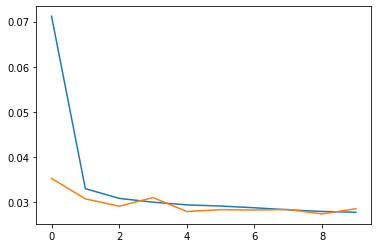

In [11]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_AGENT_ACTS_LSTM_CORRECT1.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [12]:
model.load_state_dict(torch.load('saved_models/MOVE_AGENT_ACTS_LSTM_CORRECT1.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                      precision    recall  f1-score   support

        Booking-Book      0.990     0.961     0.976       518
      Booking-Inform      0.500     0.004     0.008       518
      Booking-NoBook      0.739     0.418     0.534       122
     Booking-Request      0.808     0.361     0.499       291
        Hotel-Inform      0.853     0.808     0.830       782
       Hotel-NoOffer      0.000     0.000     0.000        65
     Hotel-Recommend      0.667     0.120     0.204       133
       Hotel-Request      0.727     0.348     0.471       267
        Hotel-Select      0.000     0.000     0.000        78
   Restaurant-Inform      0.888     0.725     0.798       690
  Restaurant-NoOffer      0.935     0.537     0.682       108
Restaurant-Recommend      0.846     0.079     0.144       140
  Restaurant-Request      0.856     0.456     0.595       287
   Restaurant-Select      0.000     0.000     0.000        81
         general-bye      0.693     0.979     0.812       675
       

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
